# PBO optimal on LQR

## Define paramters

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import jax
import os
import json

parameters = json.load(open("parameters.json"))
env_seed = parameters["env_seed"]

dummy_max_discrete_state = parameters["max_discrete_state"]

# Q function
dummy_action_range_on_max = parameters["action_range_on_max"]
dummy_n_actions_on_max = parameters["n_actions_on_max"]

# Visualisation of errors and performances
max_bellman_iterations = parameters["max_bellman_iterations"]
max_bellman_iterations_validation = max_bellman_iterations + 5
dummy_learning_rate = {"first": 0, "last": 0, "duration": 0}

# keys
env_key = jax.random.PRNGKey(env_seed)
dummy_q_network_key = env_key.copy()
dummy_pbo_network_key = env_key.copy()

## Define environment

In [2]:
import numpy as np

from pbo.environment.linear_quadratic import LinearQuadraticEnv

env = LinearQuadraticEnv(env_key, max_init_state=dummy_max_discrete_state)

Transition: s' = As + Ba
Transition: s' = 0.7204725742340088s + -0.5264108180999756a
Reward: Qs² + Ra² + 2 Ssa
Reward: -0.13297832012176514s² + -0.8039400577545166a² + 0.2581009864807129sa


## Optimal PBO

In [3]:
from tqdm.notebook import tqdm

from pbo.networks.learnable_q import LQRQ
from pbo.networks.learnable_pbo import CustomLinearPBO

q = LQRQ(
    state_dim=1,
    action_dim=1,
    n_actions_on_max=dummy_n_actions_on_max,
    action_range_on_max=dummy_action_range_on_max,
    network_key=dummy_q_network_key,
    random_weights_range=None,
    random_weights_key=None,
    learning_rate=None,
    zero_initializer=True,
)
pbo_optimal = CustomLinearPBO(q, max_bellman_iterations, False, dummy_pbo_network_key, dummy_learning_rate)
pbo_optimal.params["CustomLinearPBONet"]["slope"] = env.optimal_slope.reshape((1, 3))
pbo_optimal.params["CustomLinearPBONet"]["bias"] = env.optimal_bias.reshape((1, 3))

validation_initial_weight = q.to_weights(q.params)

weights = np.zeros((max_bellman_iterations_validation + 1, q.weights_dimension))

batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation + 1):
    weights[bellman_iteration] = batch_iterated_weights[0]
    print(weights[bellman_iteration])

    batch_iterated_weights = pbo_optimal(pbo_optimal.params, batch_iterated_weights)
    
print("Optimal weights")
print(env.optimal_weights)

[0. 0. 0.]
[-0.13297832  0.12905049 -0.80394006]
[-0.19125178  0.1716278  -0.83504903]
[-0.21394302  0.18820707 -0.8471626 ]
[-0.22232801  0.19433354 -0.85163891]
[-0.22536612  0.19655332 -0.85326076]
[-0.22645904  0.19735186 -0.85384423]
[-0.2268512   0.19763839 -0.85405356]
[-0.22699177  0.19774109 -0.8541286 ]
[-0.22704215  0.19777791 -0.85415548]
Optimal weights
[-0.22707027  0.19779846 -0.8541705 ]


## Save data

In [4]:
if not os.path.exists("figures/data/PBO_optimal/"):
    os.makedirs("figures/data/PBO_optimal/")
np.save(f"figures/data/PBO_optimal/{max_bellman_iterations}_W.npy", weights)
np.save(f"figures/data/PBO_optimal/{max_bellman_iterations}_Pi.npy", env.greedy_V(weights))

## Visualize

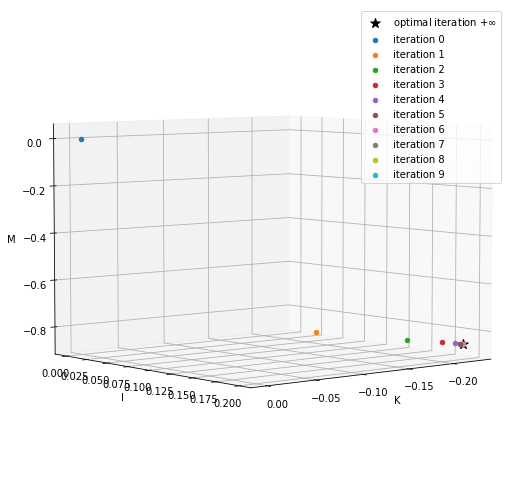

In [5]:
from pbo.utils.lqr_weights_viewer import visualize


visualize(weights, env.optimal_weights)